In [1]:
import sys
import os

_module_path = os.path.abspath("../")
print(_module_path)
sys.path.append(_module_path)

c:\Users\86994\Desktop\camera_kit


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from calibration_libs.ccalibration import CCameraCalibration
from calibration_libs.creconstruction import Reconstruction
from  calibration_libs.creconstruction import  Calc3DPose
from calibration_libs.cccparameters import CParameters


In [3]:
from calibration_libs.utils import get_chess_corners, get_chess_corners_world, img_to_world_by_dis

In [4]:
images_path =  os.path.abspath('./images_2x640x480')

In [5]:
# 标定板参数
chessSize=[11, 8] # col, row, 长边设置为col, 短边row , col作为x轴， row作为y轴
chessCellLen=20

In [6]:
#相机标定类
mycc = CCameraCalibration()  #初始化
mycc.set_calibration_images(images_path, 15, 480, 1280, size=chessSize, length=chessCellLen) #设置标定图像的路径和图片数量

['WIN_20251206_17_33_16_Pro.jpg', 'WIN_20251206_17_33_35_Pro.jpg', 'WIN_20251206_17_33_43_Pro.jpg', 'WIN_20251206_17_33_48_Pro.jpg', 'WIN_20251206_17_33_56_Pro.jpg', 'WIN_20251206_17_34_25_Pro.jpg', 'WIN_20251206_17_34_35_Pro.jpg', 'WIN_20251206_17_34_52_Pro.jpg', 'WIN_20251206_17_35_07_Pro.jpg', 'WIN_20251206_17_35_13_Pro.jpg', 'WIN_20251206_17_35_20_Pro.jpg', 'WIN_20251206_17_35_28_Pro.jpg', 'WIN_20251206_17_36_15_Pro.jpg', 'WIN_20251206_17_36_26_Pro.jpg', 'WIN_20251206_17_36_30_Pro.jpg']


In [7]:
mycc.stereo_calibration(True, reversal=False) #进行双目立体标定，得到内参矩阵、畸变系数、重映射矩阵map、重投影矩阵Q等
mycc.print_p()

左图对应相机的内参..................................
[[337.2990038    0.         294.81757204]
 [  0.         337.36806628 236.12799806]
 [  0.           0.           1.        ]]

右图对应相机的内参..................................
[[336.1642514    0.         278.93257856]
 [  0.         336.07655589 232.71658073]
 [  0.           0.           1.        ]]

重投影矩阵Q..................................
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -2.78997696e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -2.34936821e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.36722311e+02]
 [ 0.00000000e+00  0.00000000e+00  1.66738778e-02 -0.00000000e+00]]


图像形状: (480, 1280, 3)


Text(0.5, 1.0, 'Remap')

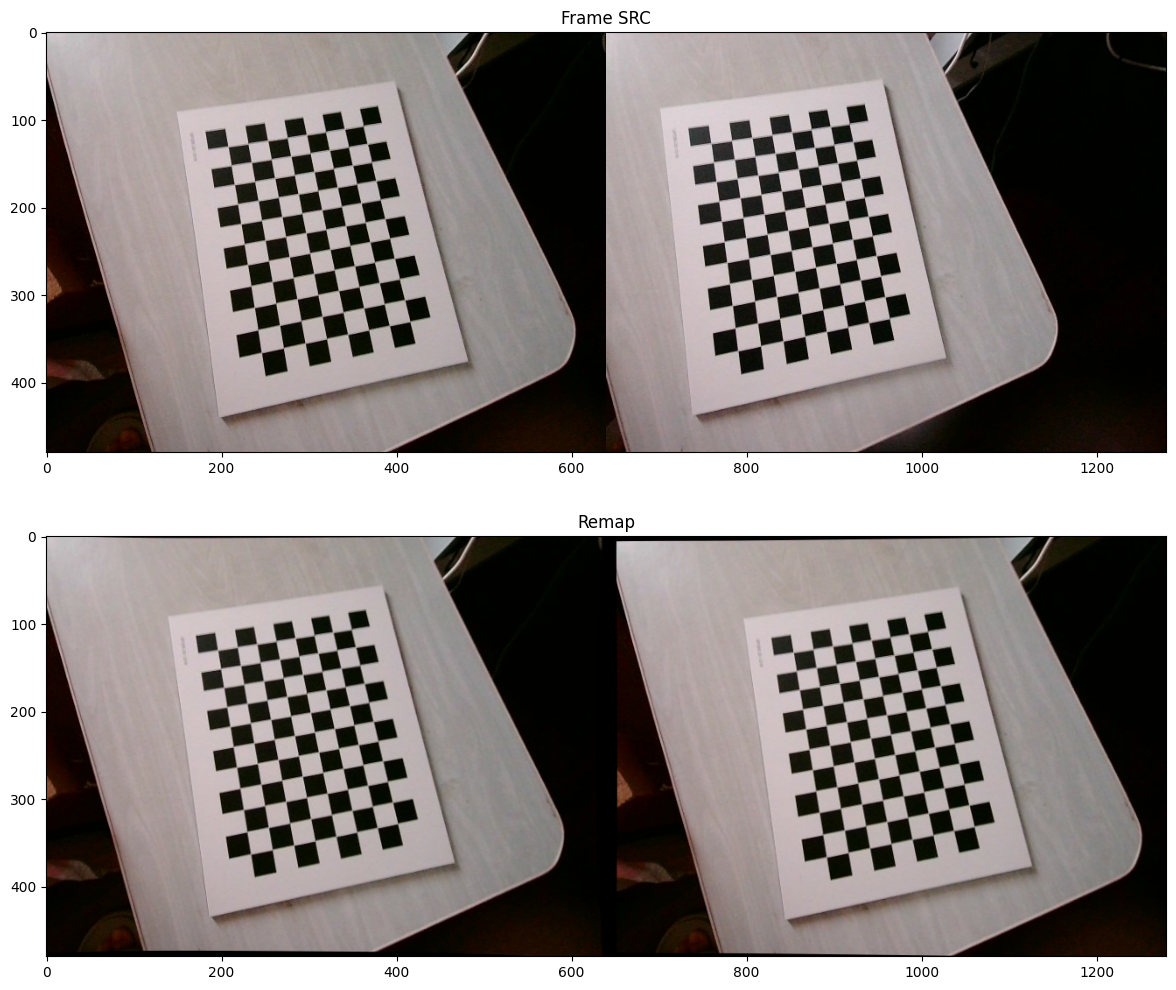

In [8]:
# 立体校正
img_src = cv2.imread('./images_2x640x480/WIN_20251206_17_33_16_Pro.jpg')
print("图像形状:", img_src.shape)
_height, _width, _c = img_src.shape
left_src = img_src[:, 0: _width//2] #拆分左右图像
right_src = img_src[:, _width//2:]

#立体校正
left_remap = cv2.remap(left_src, mycc._leftParameters["map1"], mycc._leftParameters["map2"], cv2.INTER_LINEAR)
right_remap = cv2.remap(left_src, mycc._rightParameters["map1"], mycc._rightParameters["map2"], cv2.INTER_LINEAR)
img_remap =  cv2.hconcat([left_remap, right_remap]) #合并校正后图像

plt.figure(figsize=(16,12))
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB))
plt.title("Frame SRC")   # 左图标题

plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(img_remap, cv2.COLOR_BGR2RGB))
plt.title("Remap")   # 左图标题

# 对齐校验

In [9]:
_ret, left_src_corners, _left_src_corners_draw = get_chess_corners(left_src, chessSize, draw_flag=True)
_ret, right_src_corners, _right_src_corners_draw = get_chess_corners(right_src, chessSize, draw_flag=True)
_src_draw_concat = cv2.hconcat([_left_src_corners_draw, _left_src_corners_draw]) #合并绘图

# remap 图
_ret, left_remap_corners, _left_remap_corners_draw = get_chess_corners(left_remap, chessSize, draw_flag=True)
_ret, right_remap_corners, _right_remap_corners_draw = get_chess_corners(right_remap, chessSize, draw_flag=True)
_remap_draw_concat = cv2.hconcat([_left_remap_corners_draw, _right_remap_corners_draw]) #合并绘图

Text(0.5, 1.0, 'Remap')

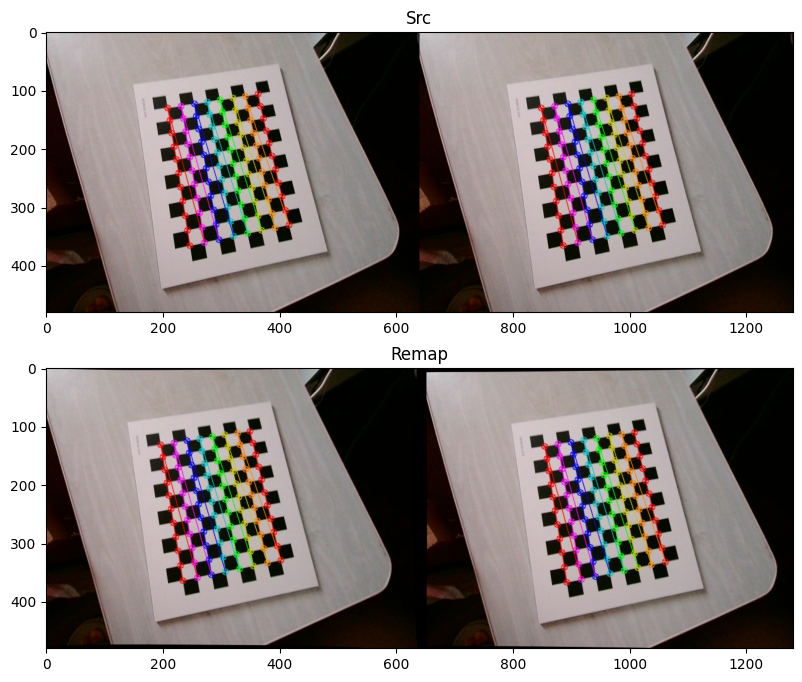

In [10]:
# 角点检测图
plt.figure(figsize=(10,8))
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(_src_draw_concat, cv2.COLOR_BGR2RGB))
plt.title("Src")  

plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(_remap_draw_concat, cv2.COLOR_BGR2RGB))
plt.title("Remap")

In [ ]:
# 绘制水平线，挑选长边竖直的图像绘制
_draw_src = img_src.copy()
_points_src_left = left_src_corners[:chessSize[0],:,:]
print(_points_src_left.shape)


[[-3.53608349e-03 -1.22964019e-03 -1.60514653e-07  1.00000000e+00]]


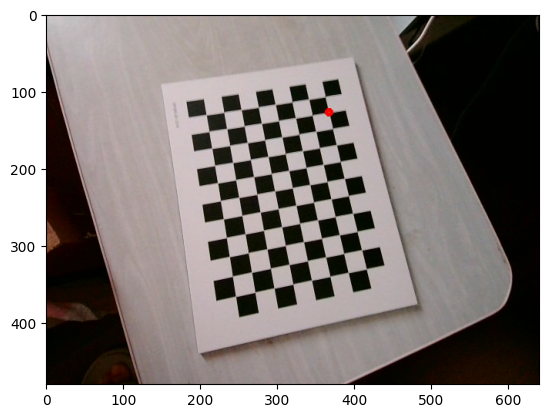

In [11]:
# 绘制水平线
_index = 1
_point_l = left_src_corners[_index]
_point_r = right_src_corners[_index]
_draw_cicle = left_src.copy()
cv2.circle(_draw_cicle, (int(_point_l[0][0]), int(_point_l[0][1])), 3, (0,0,255), 3)
plt.imshow(cv2.cvtColor(_draw_cicle, cv2.COLOR_BGR2RGB))

_world_p = img_to_world_by_dis(_point_l[0], _point_l[0][0] - _point_r[0][0], mycc._stereoCommParameters["Q"])
print(_world_p)

In [ ]:
# 对齐校验
ak = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)

In [ ]:
#相机参数的储存类
myp = CParameters()
myp.init_by_cc(mycc)